# Equivariant Vector Field Nets

In this notebook, we develop a few examples of simple De Rham Neural Networks.

In [1]:
import numpy as np
import matplotlib as mpl
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors

# Generate some graph data to play around with

In [2]:
import networkx as nx
import torch_geometric

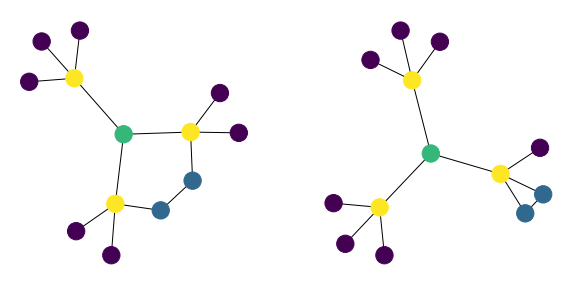

In [64]:
# draw a tree graph with 10 nodes
G = nx.balanced_tree(3, 2)

# add an edge between 4 and 11
G.add_edge(6, 11)

# draw a tree graph with 10 nodes
H = nx.balanced_tree(3, 2)

# add an edge between 7 and 8
H.add_edge(7, 8)

# calculate the spring layout for H
Gpos = nx.spring_layout(G)
Hpos = nx.spring_layout(H)



# draw the graphs on two subfigures, side by side, colored by their respective node degrees
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
nx.draw(G, pos=Gpos, with_labels=False, font_weight='bold', node_color=list(dict(G.degree()).values()))
plt.subplot(1, 2, 2)
nx.draw(H, pos=Hpos, with_labels=False, font_weight='bold', node_color=list(dict(H.degree()).values()))

## Turning graphs into tensors

In [65]:
# a function for turning a path into a chain
def nxgraph_to_chain(graph, features):
    """ 
    A function for turning a graph into a chain
    Inputs: 
        graph: an nx_graph
        features: a torch tensor of features for each node of size (m,n) where m is the number of nodes and n is the feature dimension

    outputs:
        ch: a torch tensor of shape (r,2,n) where r is the number of edges and n is the feature dimension
    """

    # get node features
    node_features = features

    # get edges
    edge_index = torch.tensor(list(graph.edges))

    # number of 1-simplices
    r = edge_index.shape[0]

    # embedding dimension
    n = node_features.shape[1]

    # sort the edge indices
    edges = torch.tensor([np.sort([edge_index[i][0],edge_index[i][1]]) for i in range(len(edge_index))])

    # initialize chain
    ch = torch.zeros((r,2,n))

    # turn edges into a 1-chain
    for i in range(r):
        ch[i,0,:] = node_features[edges[i][0]]
        ch[i,1,:] = node_features[edges[i][1]]

    return ch

In [66]:
Gpos = torch.tensor(list(Gpos.values()))
Hpos = torch.tensor(list(Hpos.values()))

In [67]:
# extract the degree sequence from the graph
degree_sequence = list(dict(G.degree()).values())

degree_sequence = torch.tensor(degree_sequence).float()

# one hot encode the degree sequence
one_hot_degree_sequence = torch.nn.functional.one_hot(degree_sequence.to(torch.int64))

one_hot_degree_sequence

tensor([[0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0]])

In [68]:
# extract the degree sequence from the graph
degree_sequence = list(dict(H.degree()).values())

degree_sequence = torch.tensor(degree_sequence).float()

# one hot encode the degree sequence
Hone_hot_degree_sequence = torch.nn.functional.one_hot(degree_sequence.to(torch.int64))

Hone_hot_degree_sequence

tensor([[0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0]])

By convention, we will always use $Z$ to denote matrix the positional, equivariant node features, and $H$ to denote the matrix of 'scalar' or non-equivariant node features. If the position of the nodes is in $\mathbb{R}^n$ and the scalar features are in $\mathbb{R}^m$, the respective matrices are in $\mathbb{R}^{s_0 \times n}$ and $\mathbb{R}^{s_0 \times m}$, where $s_0$ is the number of nodes in the graph.

In [69]:
# make a dictionary containing: the graph G, the node positions Gpos, and the one hot degree sequence, the chains
Gdata = {'graph': G, 'Z': Gpos.float(), 'H': one_hot_degree_sequence.float(), 'Z_chains': nxgraph_to_chain(G, Gpos), 'H_chains' : nxgraph_to_chain(G, one_hot_degree_sequence).float()}

# make a dictionary containing: the graph H, the node positions Hpos, and the one hot degree sequence, the chains
Hdata = {'graph': H, 'Z': Hpos.float(), 'H': Hone_hot_degree_sequence.float(), 'Z_chains': nxgraph_to_chain(H, Hpos), 'H_chains' : nxgraph_to_chain(H, Hone_hot_degree_sequence).float()}

We will also use the coboundary of the positional and scalar features. These matrices are $dZ \in \mathbb{R}^{s_1 \times n}$ and $dH \in \mathbb{R}^{s_1 \times m}$, where $s_1$ is the number of edges in the graph. These encode the tangent vector along each edge wrt these respective coordinate types.

In [70]:
Gdata['dZ'] = (Gdata['Z_chains'][:,1,:] - Gdata['Z_chains'][:,0,:])
Gdata['dH'] = (Gdata['H_chains'][:,1,:] - Gdata['H_chains'][:,0,:])
Hdata['dZ'] = (Hdata['Z_chains'][:,1,:] - Hdata['Z_chains'][:,0,:])
Hdata['dH'] = (Hdata['H_chains'][:,1,:] - Hdata['H_chains'][:,0,:])

In [71]:
Gdata['Z'].T.float() @ Gdata['H'].float()

tensor([[ 0.0000, -0.8399,  0.8857, -0.0324, -0.0135],
        [ 0.0000,  0.8849, -0.9445,  0.0387,  0.0210]])

(-1.0, 1.0)

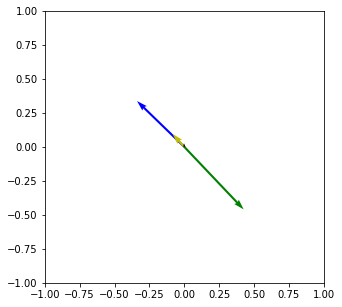

In [72]:
vec = Gdata['dZ'].T @ Gdata['dH']

# plot the columns of vec as vectors starting from the origin
plt.figure(figsize=(5,5))

# plot the columns of vec as vectors starting from the origin

plt.quiver(0, 0, vec[0,0], vec[1,0], angles='xy', scale_units='xy', scale=1, color='r')

plt.quiver(0, 0, vec[0,1], vec[1,1], angles='xy', scale_units='xy', scale=1, color='b')

plt.quiver(0, 0, vec[0,2], vec[1,2], angles='xy', scale_units='xy', scale=1, color='g')

plt.quiver(0, 0, vec[0,3], vec[1,3], angles='xy', scale_units='xy', scale=1, color='y')

plt.quiver(0, 0, vec[0,4], vec[1,4], angles='xy', scale_units='xy', scale=1, color='k')

# zoom out
plt.xlim(-1, 1)

plt.ylim(-1, 1)

# plot the columns of vec as vectors starting from the origin

(-1.0, 1.0)

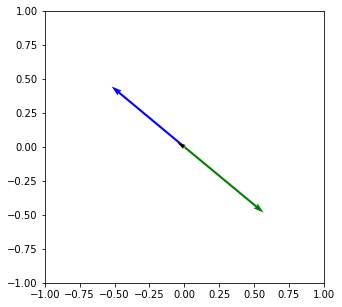

In [73]:
vec = Hdata['dZ'].T @ Hdata['dH']

# plot the columns of vec as vectors starting from the origin
plt.figure(figsize=(5,5))

# plot the columns of vec as vectors starting from the origin

plt.quiver(0, 0, vec[0,0], vec[1,0], angles='xy', scale_units='xy', scale=1, color='r')

plt.quiver(0, 0, vec[0,1], vec[1,1], angles='xy', scale_units='xy', scale=1, color='b')

plt.quiver(0, 0, vec[0,2], vec[1,2], angles='xy', scale_units='xy', scale=1, color='g')

plt.quiver(0, 0, vec[0,3], vec[1,3], angles='xy', scale_units='xy', scale=1, color='y')

plt.quiver(0, 0, vec[0,4], vec[1,4], angles='xy', scale_units='xy', scale=1, color='k')

# zoom out
plt.xlim(-1, 1)

plt.ylim(-1, 1)

# plot the columns of vec as vectors starting from the origin

In [74]:
Gdata['Z'].shape

Gdata['Z'].T @ Gdata['H']

base = torch.cat((Gdata['Z'].T @ Gdata['H'], Gdata['dZ'].T @ Gdata['dH']),axis=1)

base.shape

torch.Size([2, 10])

In [75]:
# build a random tensor of 7x2 
X = torch.rand(7,2)

# shape is batch x (2*non-eq dim)
(X @ base).shape

torch.Size([7, 10])

In [76]:
dimH = 5
dimZ = 2

num_vf = 3

# generate a torch sequential neural network with two hidden layers
model = nn.Sequential(nn.Linear(2*dimH, 512), 
                      nn.LeakyReLU(), 
                      nn.Linear(512, 256), 
                      nn.LeakyReLU(), 
                      nn.Linear(256, (1+2*dimH)*num_vf)
                      )

In [77]:
model(X @ base).shape

out = model(X @ base)

In [78]:
out.shape

torch.Size([7, 33])

In [79]:
print(X.shape)
print(base.shape)

# for each row of X, concatenate the transpose of the rwo iwth the base
c = torch.cat((X.T, base), axis=1)


Y = X.unsqueeze(-1)

print(Y.shape)


# stack the bases along the batch dimension
bases = torch.stack([base] * X.shape[0])

print(bases.shape)

# create a list with X.shape[0] copies of base without using a for loop

full_bases = torch.cat((Y,bases),axis=-1)

full_bases.shape

torch.Size([7, 2])
torch.Size([2, 10])
torch.Size([7, 2, 1])
torch.Size([7, 2, 10])


torch.Size([7, 2, 11])

In [80]:
out = out.view(-1, num_vf, 1+2*dimH)

# switch 1st and 2nd dimensions
out = out.permute(0,2,1)

out.shape

torch.Size([7, 11, 3])

In [81]:
full_bases.shape

torch.Size([7, 2, 11])

In [82]:
# this is the output containing the vector field values of each batch
final = torch.matmul(full_bases, out)

print("final.shape: " , final.shape)

# we wrap it up into the correct format for integration matrix layer
finalwrap = final.view(-1, dimZ * num_vf)

finalwrap.shape

final.shape:  torch.Size([7, 2, 3])


torch.Size([7, 6])

In [83]:
# create a forward pass
def fwd(X, model, base):
    """ 
    A function for performing a forward pass of the equivariant layer

    Inputs:
        X: a torch tensor of shape (batch, z)
        model: a torch sequential model
        base: a torch tensor of shape (z, h)
    
    Outputs:
        finalwrap: a torch tensor of shape (batch, z, num_vf)

    """

    # apply the model to the invariant summary
    out = model(X @ base)

    # stack the bases along the batch dimension
    bases = torch.stack([base] * X.shape[0])

    # 
    Y = X.unsqueeze(-1)

    full_bases = torch.cat((Y,bases),axis=-1)

    out = out.view(-1, num_vf, 1+2*dimH)

    # switch 1st and 2nd dimensions
    out = out.permute(0,2,1)

    # this is the output containing the vector field values of each batch
    final = torch.matmul(full_bases, out)

    return final

In [84]:
fwd(X,model,base).shape

torch.Size([7, 2, 3])

In [85]:
base.shape

# times the base on the right by a 2d rotation matrix of angle 
def rot(base, angle):
    R = torch.tensor([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    return R.float() @ base 

# times the base on the right by a 2d rotation matrix of angle

Rbase = rot(base, np.pi)

Rbase.shape

torch.Size([2, 10])

In [86]:
inp = torch.tensor([[0.1,0.5]]).float()

fwd(inp,model,base)

tensor([[[-0.0334,  0.0334,  0.0077],
         [ 0.0441, -0.0138,  0.0088]]], grad_fn=<UnsafeViewBackward0>)

In [87]:
def simple_vf_plot(model, base, ax, radius = 1, comp = 0):
    x = np.linspace(-radius,radius,10)
    y = np.linspace(-radius,radius,10)
    X,Y = np.meshgrid(x,y)

    X = torch.tensor(X).double()
    Y = torch.tensor(Y).double()


    U = np.zeros((10,10))
    V = np.zeros((10,10))
    for i in range(10):
        for j in range(10):
            inp = np.array([X[i,j],Y[i,j]])
            inp = torch.tensor([inp]).float()


            tv = fwd(inp,model,base).detach().numpy()[0][:,comp]


            U[i,j] = tv[0]
            V[i,j] = tv[1]
    ax.quiver(X,Y,U,V)

In [88]:
# times the base on the right by a 2d rotation matrix of angle 
def rot(base, angle):
    R = torch.tensor([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    return R.float() @ base 

def rot2(pos, angle):
    R = torch.tensor([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    return pos.float() @ R.T.float()


We check that the rotations of the base indeed induce a corresponding rotation of the vector field.

Text(0.5, 0.98, 'Vector field for different rotations of the base')

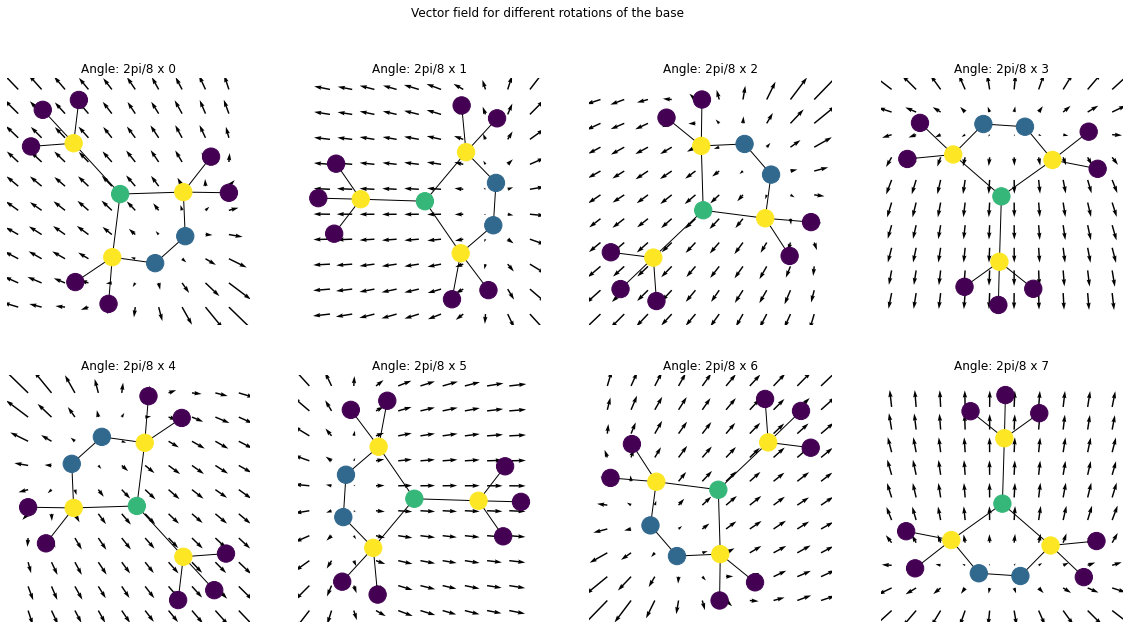

In [90]:
angles = np.arange(0,2*np.pi,2*np.pi/8)

comp = 0

fig, ax = plt.subplots(2,4,figsize=(20,10))

for i in range(8):
    simple_vf_plot(model, rot(base,angles[i]), ax[i//4,i%4], comp=comp)
    plt.subplot(2, 4, i+1)
    nx.draw(G, pos=rot2(Gpos,angles[i]), with_labels=False, font_weight='bold', node_color=list(dict(G.degree()).values()))

    # title the subplot with the angle in radians
    plt.title('Angle: ' + str("2pi/8 x ") + str(i) )


# give the plot a title
plt.suptitle('Vector field for different rotations of the base')

An interesting remark is that the symmetries of the graph embedding are preserved as symmetries of the vector field. See the report for a basic mathematical proof of this fact.

## General Data Tensorization

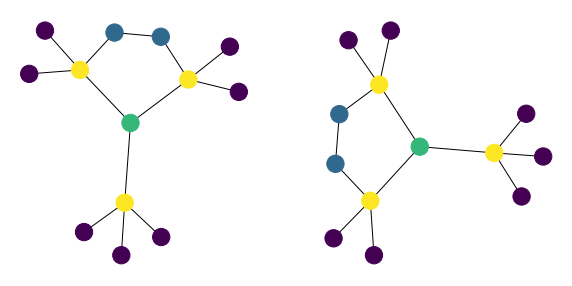

In [33]:
# draw a tree graph with 10 nodes
G = nx.balanced_tree(3, 2)

# add an edge between 4 and 11
G.add_edge(6, 11)


# calculate the spring layout for H
Gpos = torch.tensor(list(nx.spring_layout(G).values()))

# draw the graphs on two subfigures, side by side, colored by their respective node degrees
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
nx.draw(G, pos=Gpos, with_labels=False, font_weight='bold', node_color=list(dict(G.degree()).values()))

Gpos_rot = rot2(Gpos, np.pi/2)

plt.subplot(1, 2, 2)
nx.draw(G, pos=Gpos_rot, with_labels=False, font_weight='bold', node_color=list(dict(G.degree()).values()))

In [34]:
# a function for turning graph features into tensors
def tensorize(G, Z, H):
    """ 
    A function for extracting graph embedding data:
    Inputs: 
        G: an nx_graph
        Z: a torch tensor of equivariant features of size (m_0,n) 
                where m_0 is the number of nodes and n is the equivariant feature dimension
        H: a torch tensor of non-equivariant features of size (m_0,l) 
                where m_0 is the number of nodes and l is the feature dimension
        
    Outputs:
        Gdata: a dictionary containing the graph, the node positions, the one hot degree sequence, the chains, and the B matrix
    """

    # make a dictionary containing: the graph G, the node positions Gpos, and the one hot degree sequence, the chains
    Gdata = {'graph': G, 'Z': Z.float(), 'H': H.float(), 'Z_chains': nxgraph_to_chain(G, Z).float(), 'H_chains' : nxgraph_to_chain(G, H).float()}

    Gdata['dZ'] = (Gdata['Z_chains'][:,1,:] - Gdata['Z_chains'][:,0,:])
    Gdata['dH'] = (Gdata['H_chains'][:,1,:] - Gdata['H_chains'][:,0,:])

    Gdata['B'] = torch.cat((Gdata['Z'].T @ Gdata['H'], Gdata['dZ'].T @ Gdata['dH']), axis=1)

    return Gdata

In [35]:
# make 
Gdata = tensorize(G,Z=Gpos,H=one_hot_degree_sequence)


## Integration

Now we prepare the code for integration of the edges in the graph against the vector field. We will use the trapezoidal rule for this.

In [36]:
# a function for turning a path into a chain
def graph_to_chain(graph):
    """ 
    A function for turning a graph into a chain
    """

    # get node features
    node_features = torch.tensor(graph['x'])

    # get edges
    edge_index =torch.tensor(data['edge_index']).T

    # number of 1-simplices
    r = edge_index.shape[0]

    # embedding dimension
    n = node_features.shape[1]

    # sort the edge indices
    edges = torch.tensor([np.sort([edge_index[i][0],edge_index[i][1]]) for i in range(len(edge_index))])

    # initialize chain
    ch = torch.zeros((r,2,n))

    # turn edges into a 1-chain
    for i in range(r):
        ch[i,0,:] = node_features[edges[i][0]]
        ch[i,1,:] = node_features[edges[i][1]]

    return ch

def path_to_chain(p):
    """  
    A function for turning a path into a chain

    Parameters
    ----------
    p : numpy array
        A path in R^n, represented as a numpy array of shape (p,n), where p is the number of points in the path

    Returns
    -------
    chain : numpy array
        A chain in R^n, represented as a numpy array of shape (p-1,2,n), where p is the number of points in the path.
        The middle index corresponds to start and endpoints of the edges in the chain.
    """

    r = len(p) - 1

    n = p[0].shape[0]
    
    
    chain = torch.zeros((r,2,n))

    chain[:,1,:] = torch.tensor(p[1:,:])
    chain[:,0,:] = torch.tensor(p[0:-1,:])

    return chain

    
# a function for turning a chain into a discretized chain
def discretize_chain(chain,d):
    """ 
    A function for turning a chain into a discretized chain

    Parameters
    ----------
    chain : numpy array
        A chain in R^n, represented as a numpy array of shape (p-1,2,n), where p is the number of points in the path.

    d : int
        The number of points in the discretized chain

    Returns
    -------
    d_chain : numpy array
        A discretized chain in R^n, represented as a numpy array of shape (p-1,d,n), where p is the number of points in the path.

    """

    r = chain.shape[0]

    n = chain.shape[2]

    d_chain = torch.zeros((r,d,n))

    t = np.linspace(0,1,d)

    for i in range(d):

        d_chain[:,i,:] = (1-t[i]) * chain[:,0,:] + t[i] * chain[:,1,:] 

    return d_chain


In [38]:
# create a forward pass
def Vfwd(X, model, base):
    """ 
    A function for performing a forward pass of the equivariant layer

    Inputs:
        X: a torch tensor of shape (batch, z)
        model: a torch sequential model
        base: a torch tensor of shape (z, h)
    
    Outputs:
        finalwrap: a torch tensor of shape (batch, z, num_vf)

    """

    # original shape of X
    orig_shape = X.shape

    # apply the model to the invariant summary
    out = model(X @ base)

    # add a dimension to X
    Y = X.unsqueeze(-1)

    # combine dimensions 1 and 2 of Y so that batch/edge and discrete steps are combined
    Y = Y.reshape(Y.shape[0]*Y.shape[1],Y.shape[2], Y.shape[3])


    bases = torch.stack([base] * Y.shape[0])

    # concat the bases along the batch dimension
    # these are the base vectors which generate the vector field
    full_bases = torch.cat((Y,bases),axis=-1)

    # reshape the output of the model
    out = out.view(-1, num_vf, 1+2*dimH)

    # switch 1st and 2nd dimensions
    out = out.permute(0,2,1)

    # this is the output containing the vector field values of each batch
    final = torch.matmul(full_bases, out)

    return final

In [39]:
# a function for turning a chain into a cochain data matrix
def equi_integratrix(vf,chain, B, d = 5):
    """
    A function for generating an integratrix from a chain and a vector field

    Parameters
    ----------
    vf : a Pytorch Sequential object
        The vector field to be applied to the chain
    
    chain : a torch tensor of shape (r,2,n)
        The chain to be turned into a cochain data matrix

    B : a torch tensor of shape (z,h)
        The invariant summary matrix of the chain

    d : int
        The number of discrete steps in the discretization of the chain
    
    Returns
    -------
    out : a torch tensor of shape (r,c)
        The cochain data matrix
    """

    
    # discretize the chain
    chain = discretize_chain(chain, d)

    # number of simplicies
    r = chain.shape[0]

    # number of discrete steps
    d = chain.shape[1]

    # dimension of ambient space
    n = chain.shape[2]

    # number of feature-cochains in the cochain data matrix
    c = int(vf[-1].out_features)

    # apply the vector field to the discretized chain
    out = Vfwd(chain, vf, B).reshape((r,d,n,-1))

    # calculate the simplex gradients
    simplex_grad = chain[:,1,:] - chain[:,0,:]

    # swap dimensions n and c in out
    out = out.permute(0,1,3,2)

    # calculate the inner product of the vector field and the simplex gradients at each discrete step on each simplex
    inner_prod = torch.matmul(out,simplex_grad.T/(d-1))

    # take diagonal of out3 along axis 0 and 3 (this corresponds to correcting the broadcasted multplication effect)
    inner_prod = torch.diagonal(inner_prod, dim1 = 0, dim2 = 3)

    # permute dimensions 0 and 2 of out4
    inner_prod = inner_prod.permute(2,0,1)

    # apply the trapzoidal rule to the inner product
    cdm = (inner_prod[:,1:,:] + inner_prod[:,0:-1,:])/2
    cdm = cdm.sum(axis = 1)

    return cdm

### $SO(n)$ Invariance of Integratrices

In theory, rotated/reflected copies of an embedded graph should produce the same integratix against our equivariant vector field. An important aspect is that the vector field does require the specific rotation of the graph to be known. Thus, if two graphs are related by an unknown rotation they will automatically produce the same integratrix without having to align them in any way. In summary, $SO(n)$-equivariant vector fields produce $SO(n)$-invariant integratrices, and do not require any alignment. We confirm this numerically below. 

In [62]:
# make a rotated version of G
Gdata_rot = tensorize(G,Z=rot2(Gpos,np.pi/2),H=one_hot_degree_sequence)

# calculate integratrices, note pi/2 is not an input
A = equi_integratrix(model, Gdata['Z_chains'], Gdata['B'])
B = equi_integratrix(model, Gdata_rot['Z_chains'], Gdata_rot['B'])

# compare the integratrices
A-B < 1e-8

tensor([[True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True]])

# Synthetic Example
## Graph Isomorphism Testing

In this synthetic example, we will embed two different isomorphic classes of graphs using the spring layout. Recomputing the spring layout for each graph will produce different embeddings which will be close to isometric with minor variations. 

In [293]:
# generate 10 different non-isomorphic graphs with the same nodes, edges and degree sequence
graphs = [nx.random_degree_sequence_graph([3,3,3,3,3,2,2,1,1,1], tries=100) for i in range(3)]

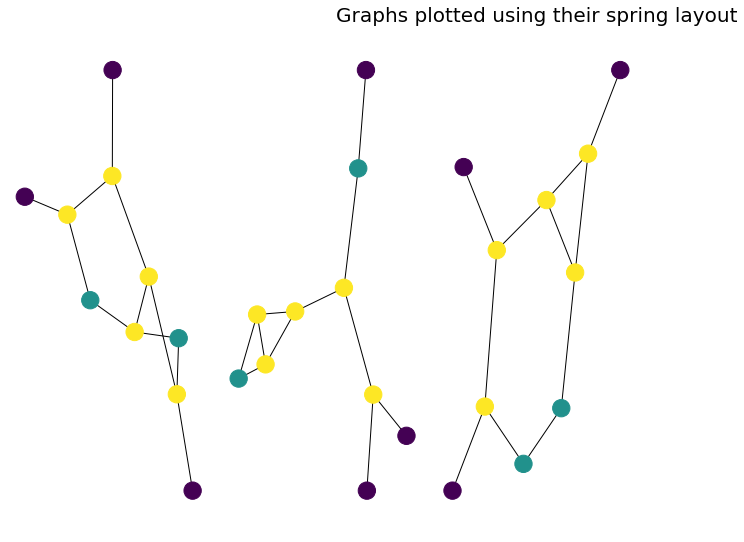

In [294]:
# plot the graphs
plt.figure(figsize=(15,15))

for i in range(3):
    plt.subplot(2, 5, i+1)
    nx.draw(graphs[i], pos=nx.spring_layout(graphs[i]), with_labels=False, font_weight='bold', node_color=list(dict(graphs[i].degree()).values()))

# add title
plt.suptitle('Graphs plotted using their spring layout', fontsize=20)

# center the title
plt.tight_layout()

/Users/maggs/miniconda3/envs/cochainrl/lib/python3.11/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Users/maggs/miniconda3/envs/cochainrl/lib/python3.11/site-packages/matplotlib/collections.py:1419: ComplexWarning: Casting complex values to real discards the imaginary part
  else mpath.Path(np.asarray(seg, float))
/Users/maggs/miniconda3/envs/cochainrl/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


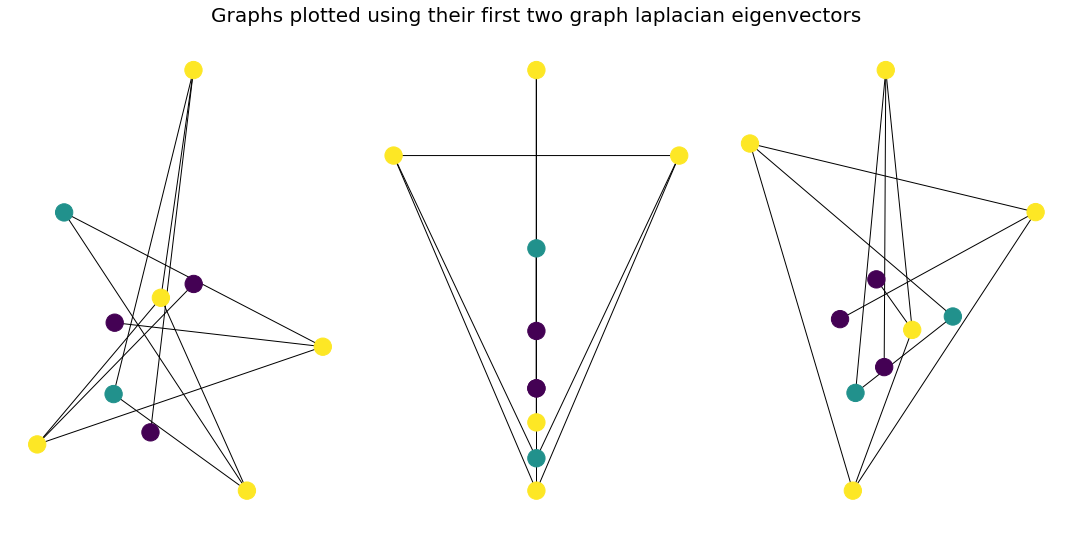

In [295]:
# calculate the first two graph laplacian eigenvectors
eigvecs = [torch.linalg.eig(torch.tensor(nx.laplacian_matrix(graph).todense()).float())[1][:,1:3] for graph in graphs]

# plot the graphs using their first two graph laplacian eigenvectors
plt.figure(figsize=(15,15))

for i in range(3):
    plt.subplot(2, 3, i+1)
    nx.draw(graphs[i], pos=eigvecs[i].detach().numpy(), with_labels=False, font_weight='bold', node_color=list(dict(graphs[i].degree()).values()))

# add title
plt.suptitle('Graphs plotted using their first two graph laplacian eigenvectors', fontsize=20)

# center the title
plt.tight_layout()


Text(0.5, 0.98, 'Graphs plotted using their first two graph laplacian eigenvectors')

/Users/maggs/miniconda3/envs/cochainrl/lib/python3.11/site-packages/matplotlib/text.py:757: ComplexWarning: Casting complex values to real discards the imaginary part
  posx = float(self.convert_xunits(self._x))
/Users/maggs/miniconda3/envs/cochainrl/lib/python3.11/site-packages/matplotlib/text.py:758: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(self.convert_yunits(self._y))


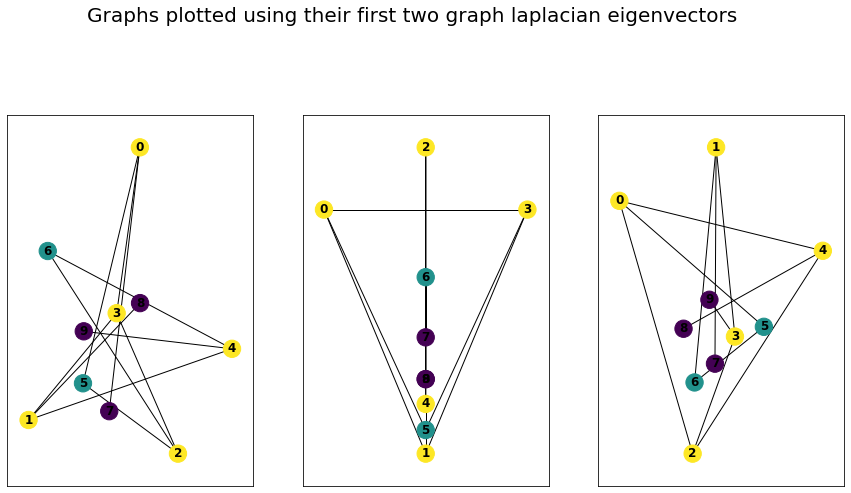

In [296]:
# make the same plot with axis labels
plt.figure(figsize=(15,15))


for i in range(3):
    plt.subplot(2, 3, i+1)
    nx.draw(graphs[i], pos=eigvecs[i].detach().numpy(), with_labels=True, font_weight='bold', node_color=list(dict(graphs[i].degree()).values()))
    
    # show x-y axis
    plt.axis('on')

    # show axis ticks
    plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)


# add title
plt.suptitle('Graphs plotted using their first two graph laplacian eigenvectors', fontsize=20)




### Learning Characteristic Vector Fields

The goal of this experiment is purely pedagogical. We wish to give the learning algorithm the objective of learning a vector field which is characteristic of the graph class. The idea is that each vector field should produce a large integratrix for its own graph and a small integratrix for the other graph.

In [297]:
# data transformation 

# one hot encode the degree sequence
one_hot_degree_sequence = torch.nn.functional.one_hot(torch.tensor([3,3,3,3,3,2,2,1,1,1])).float()

# tensorize the graphs with the laplacian eigenvectors as the equivariant features
# and the one hot degree sequence as the non-equivariant features
data = [tensorize(graphs[i], Z=eigvecs[i], H=one_hot_degree_sequence) for i in range(3)]

In [315]:
dimH = 4
dimZ = 2
num_vf = 3

# generate a torch sequential neural network with two hidden layers
isomodel = nn.Sequential(nn.Linear(2*dimH, 512), 
                      nn.LeakyReLU(), 
                      nn.Linear(512, 256), 
                      nn.LeakyReLU(), 
                      nn.Linear(256, (1+2*dimH)*num_vf)
                      )

In [357]:
def simple_vf_plot2(model, base, ax, radius = 1, comp = 0):
    x = np.linspace(-radius,radius,20)
    y = np.linspace(-radius,radius,20)
    X,Y = np.meshgrid(x,y)

    X = torch.tensor(X).double()
    Y = torch.tensor(Y).double()


    U = np.zeros((20,20))
    V = np.zeros((20,20))
    for i in range(20):
        for j in range(20):
            inp = np.array([X[i,j],Y[i,j]])
            inp = torch.tensor([inp]).float()


            tv = fwd(inp,model,base).detach().numpy()[0][:,comp]


            U[i,j] = tv[0]
            V[i,j] = tv[1]
    ax.quiver(X,Y,U,V)

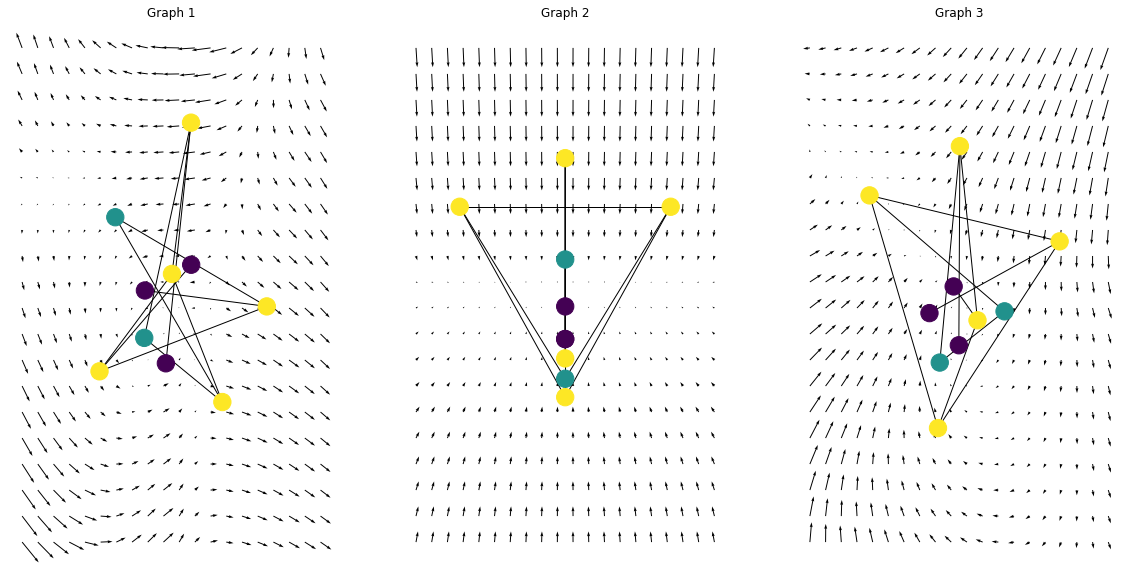

In [316]:
# plot the graphs and initialized vector fields
fig, ax = plt.subplots(1,3,figsize=(20,10))

for i in range(3):
    simple_vf_plot2(isomodel, data[i]['B'], ax[i%5], comp=0)
    plt.subplot(1, 3, i+1)
    nx.draw(graphs[i], pos=eigvecs[i].detach().numpy(), with_labels=False, font_weight='bold', node_color=list(dict(graphs[i].degree()).values()))

    # title the subplot with the angle in radians
    plt.title('Graph ' + str(i+1) )





In [317]:
labels = torch.tensor([0,1,2])

# intialise cross-entropy loss and adam optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(isomodel.parameters(), lr=0.001)

In [330]:
# train the model
for epoch in range(20):  # loop over the dataset multiple times

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = [equi_integratrix(isomodel, data[i]['Z_chains'], data[i]['B']) for i in range(3)]

    for i in range(3):

        X = outputs[i]

        #X = torch.sum(X, axis = 0)
        X = torch.diag(X.T @ X)

        # perform softmax on X
        X = torch.nn.functional.softmax(X)

        outputs[i] = X

    loss = sum([criterion(outputs[i], labels[i]) for i in range(3)])
    loss.backward()
    optimizer.step()

    
    # print statistics every 5 epochs
    if epoch % 5 == 0:    
        print('Epoch: ', epoch, 'Loss: ', loss.item())


    # print training accuracy 


Epoch:  0 Loss:  2.4825267791748047
Epoch:  5 Loss:  2.0264978408813477


/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_2045/2116001018.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = torch.nn.functional.softmax(X)


/Users/maggs/miniconda3/envs/cochainrl/lib/python3.11/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Users/maggs/miniconda3/envs/cochainrl/lib/python3.11/site-packages/matplotlib/collections.py:1419: ComplexWarning: Casting complex values to real discards the imaginary part
  else mpath.Path(np.asarray(seg, float))
/Users/maggs/miniconda3/envs/cochainrl/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


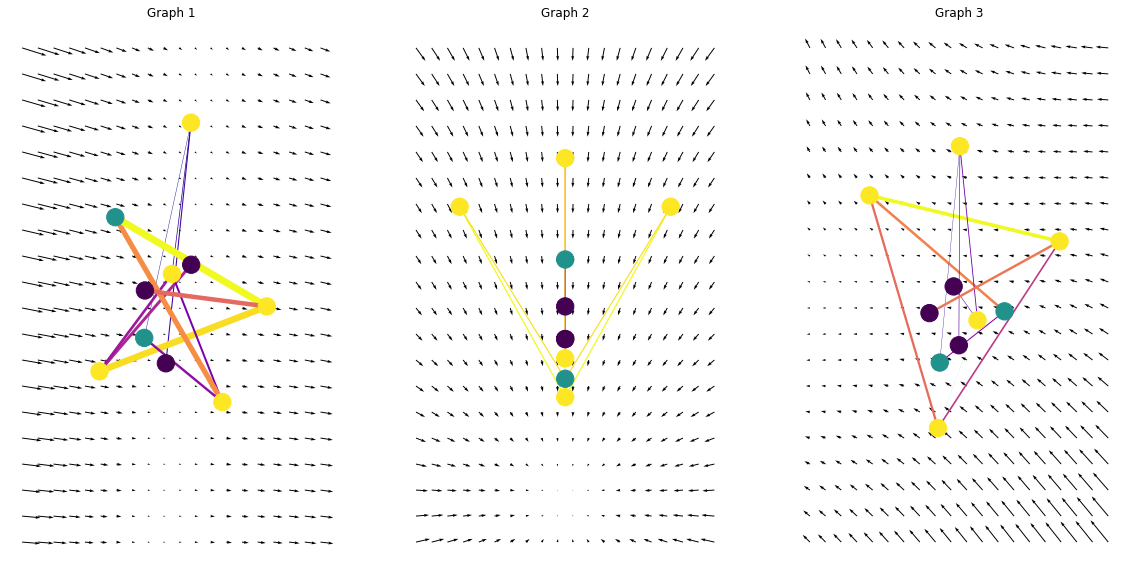

In [333]:
# plot the graphs and vector fields
fig, ax = plt.subplots(1,3,figsize=(20,10))

comp = 0

for i in range(3):
    simple_vf_plot2(isomodel, data[i]['B'], ax[i%5], comp=comp)
    plt.subplot(1, 3, i+1)
    nx.draw(graphs[i], pos=eigvecs[i].detach().numpy(), with_labels=False, font_weight='bold', node_color=list(dict(graphs[i].degree()).values()), edge_cmap = plt.cm.plasma, edge_color = 5*outputs[i][:,comp].detach().numpy(), width=5*outputs[i][:,comp].detach().numpy())



    # title the subplot with the angle in radians
    plt.title('Graph ' + str(i+1) )

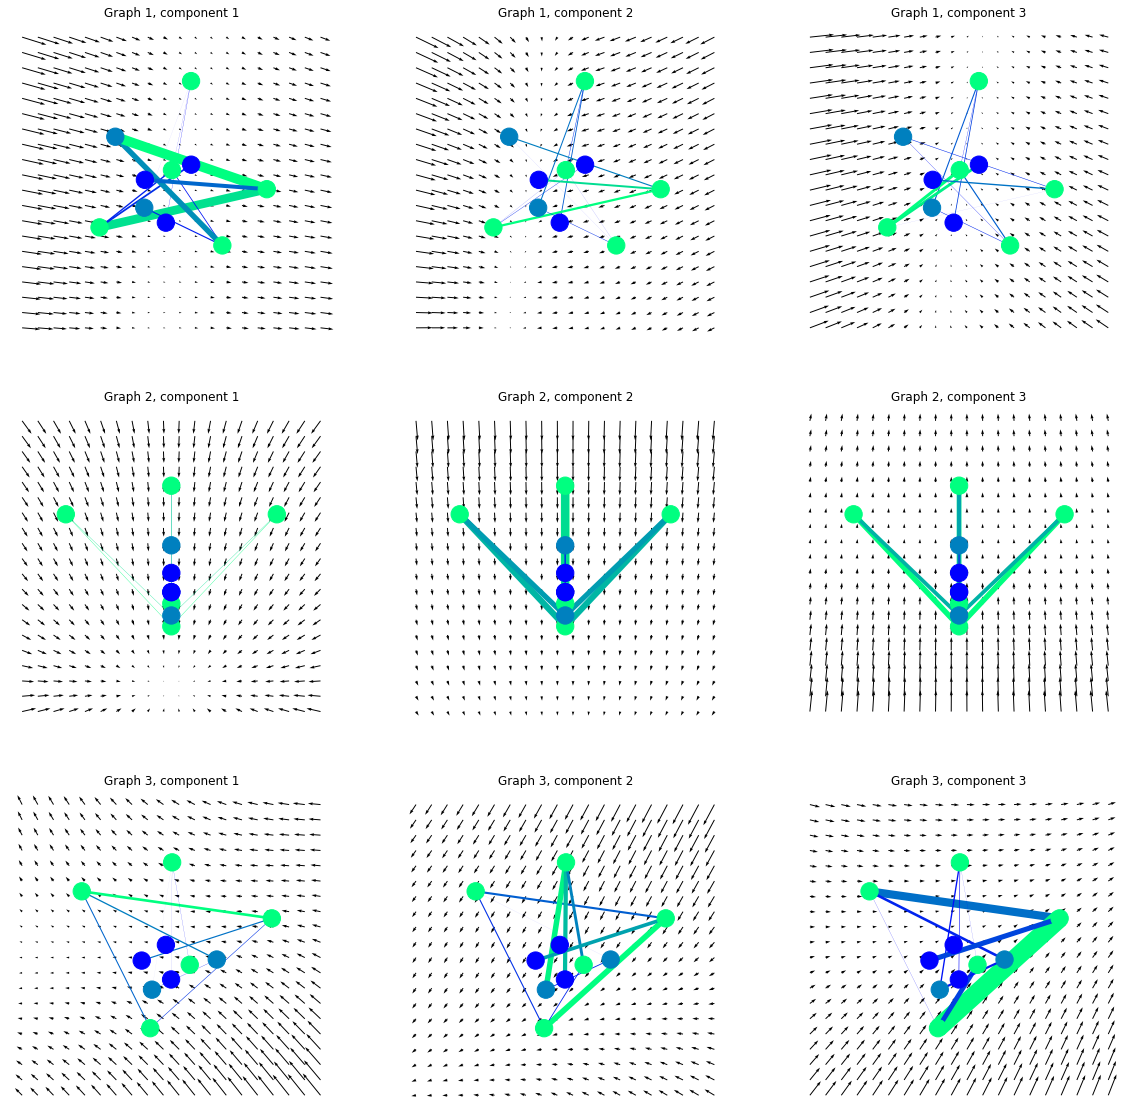

In [356]:
# make the same plot in a 3x3 iterating over the components of the vector field
fig, ax = plt.subplots(3,3,figsize=(20,20))

outputs = [(equi_integratrix(isomodel, data[i]['Z_chains'], data[i]['B']))**2 for i in range(3)]

for i in range(3):
    for j in range(3):
        simple_vf_plot2(isomodel, data[i]['B'], ax[i,j], comp=j)
        plt.subplot(3, 3, 3*i+j+1)
        nx.draw(graphs[i], pos=eigvecs[i].detach().numpy(), with_labels=False, font_weight='bold', cmap = plt.cm.winter, node_color=list(dict(graphs[i].degree()).values()), edge_cmap = plt.cm.winter, edge_color = 5*outputs[i][:,j].detach().numpy(), width=5*outputs[i][:,j].detach().numpy())



        # title the subplot with the angle in radians
        plt.title('Graph ' + str(i+1) + ', component ' + str(j+1) )

# swap the subplots of the figure by a transposition
ax = ax.T

In [344]:
# calculate test accuracy
outputs = [equi_integratrix(isomodel, data[i]['Z_chains'], data[i]['B']) for i in range(3)]

for i in range(3):
    
        X = outputs[i]
    
        X = torch.diag(X.T @ X)
    
        # perform softmax on X
        X = torch.nn.functional.softmax(X)
    
        outputs[i] = X


# calculate test accuracy
correct = 0
total = 0

for i in range(3):
    total += 1
    if torch.argmax(outputs[i]) == labels[i]:
        correct += 1

print('Test Accuracy: ', correct/total)


Test Accuracy:  1.0


/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_2045/4285167842.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = torch.nn.functional.softmax(X)


In [345]:
outputs = torch.stack(outputs)

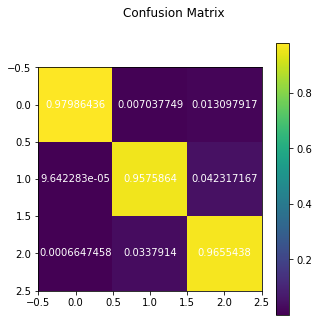

In [346]:
# plot outputs as a heatmap
plt.figure(figsize=(5,5))
plt.imshow(outputs.detach().numpy(), cmap='viridis' , interpolation='nearest')
plt.colorbar()

# add an argument to imshow to display the values of outputs
for i in range(3):
    for j in range(3):
        plt.text(j, i, outputs[i,j].detach().numpy(), ha="center", va="center", color="w")


# add a title confusion matrix
plt.suptitle("Confusion Matrix")

plt.show()


In [873]:
def plot_chain(chain, ax):

    # for each row in chain, plot the line segment connecting chain[i,0,:] to chain[i,1,:]
    for i in range(chain.shape[0]):
        ax.plot(chain[i,:,0],chain[i,:,1], color='g')


In [29]:
# restrict the chain to nodes with L1 norm less than 1

def restrict_chain(chain, radius):

    """
    A function for restricting a chain to nodes with L1 norm less than 1

    Parameters
    ----------
    chain : a torch tensor of shape (r,2,n)
        The chain to be restricted

    radius : float
        The radius
    
    Returns
    -------
    out : a subset of chain with rows corresponding to nodes with L1 norm less than 1
    """

    # calculate the L1 norm of each node
    norms = torch.sum(torch.abs(chain), axis = 2)

    radius = radius * chain.shape[2]


    # identify rows where norms[:,0] and norms[:,1] are less than radius
    indices = np.where((norms[:,0] < radius) & (norms[:,1] < radius))



    # return the subset of chain with rows corresponding to nodes with L1 norm less than 1
    out = chain[indices]
    

    return out

In [31]:
def simple_vf_plot(vf, ax, radius = 1):
    x = np.linspace(-radius,radius,10)
    y = np.linspace(-radius,radius,10)
    X,Y = np.meshgrid(x,y)

    X = torch.tensor(X).double()
    Y = torch.tensor(Y).double()


    U = np.zeros((10,10))
    V = np.zeros((10,10))
    for i in range(10):
        for j in range(10):
            inp = np.array([X[i,j],Y[i,j]])
            inp = torch.tensor(inp).float()

            tv = vf.forward(inp)

            U[i,j] = tv[0]
            V[i,j] = tv[1]
    ax.quiver(X,Y,U,V)


In [38]:
# add 'h' to each elem in dataset consisting of a vector of ones of length x.shape[0]
def add_h(dataset):
    """
    A function for adding 'h' to each elem in dataset consisting of a vector of ones of length x.shape[0]

    Parameters
    ----------
    dataset : a list of torch geometric data objects
        The dataset to be modified
    
    Returns
    -------
    out : a list of torch geometric data objects
        The modified dataset
    """

    out = []

    for data in dataset:
        data['h'] = torch.ones(data['x'].shape[0])
        data['h'] = data['h'].reshape((data['h'].shape[0],1))
        out.append(data)

    return out

dataset = add_h(dataset)

In [44]:
def add_sym(dataset):

    """
    A function for adding 'sym' to each elem in dataset consisting of a vector of ones of length x.shape[0]

    Parameters
    ----------
    dataset : a list of torch geometric data objects
        The dataset to be modified
    
    Returns
    -------
    out : a list of torch geometric data objects
        The modified dataset
    """

    out = []

    for data in dataset:
        data['sym'] = data['h'].T @ data['x'] @ data['x'].T @ data['h']
        data['sym'] = data['sym'].reshape((data['sym'].shape[0],1))
        out.append(data)

    return out

In [45]:
dataset = add_sym(dataset)

In [48]:
graph = dataset[0]

graph['sym'].flatten()

tensor(2.1316e-14)

In [43]:
graph['h'].T @ graph['x'] @ graph['x'].T @ graph['h']

tensor([[2.1316e-14]])

In [21]:
trans = create_grid(20)

In [67]:
## intialise a neural 1-form/vector field in R^2
c = 1 # non-equivariant feature dim
d = 2 # ambient dim
m = 1 # 1-form feat dim

equivec = nn.Sequential(
    nn.Linear(c*c+d, 32),
    nn.LeakyReLU(),
    nn.Linear(32, 32),
    nn.LeakyReLU(),
    nn.Linear(32, m)
)

In [69]:
def equi_vf_plot(vf, graph, ax, radius = 1):
    x = np.linspace(-radius,radius,10)
    y = np.linspace(-radius,radius,10)
    X,Y = np.meshgrid(x,y)

    X = torch.tensor(X).double()
    Y = torch.tensor(Y).double()


    U = np.zeros((10,10))
    V = np.zeros((10,10))
    for i in range(10):
        for j in range(10):
            inp = np.array([X[i,j],Y[i,j]])
            inp = torch.tensor(inp).float()

            sym = graph['sym'].flatten()

            inp = torch.cat((sym,inp),0)
            tv = vf.forward(inp)

            tv = graph['x'].T @ graph['h'] @ tv

            print(tv)


            U[i,j] = tv[0]
            V[i,j] = tv[1]
    ax.quiver(X,Y,U,V)


In [70]:
# return a rotation matrix in R^2 based on an angle
def rot_mat(theta):
    """
    A function for returning a rotation matrix in R^2 based on an angle

    Parameters
    ----------
    theta : float
        The angle of rotation
    
    Returns
    -------
    out : a torch tensor of shape (2,2)
        The rotation matrix
    """

    out = torch.tensor([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])

    # turn out so everything is a float
    out = out.float()
    

    return out

graph2 = graph.clone()

graph2['x'] = graph2['x'] @ rot_mat(np.pi/4)

graph2['sym'] = graph2['h'].T @ graph2['x'] @ graph2['x'].T @ graph2['h']



In [73]:
graph['x']

tensor([[-0.2825,  0.1352],
        [-0.4072,  0.4841],
        [-0.5845,  0.7524],
        [-0.8121,  0.8912],
        [-0.9960,  0.7797],
        [-0.9046,  0.5556],
        [-0.6498,  0.3951],
        [-0.3075,  0.3098],
        [ 0.0623,  0.2598],
        [ 0.4042,  0.1701],
        [ 0.7010,  0.0183],
        [ 0.9160, -0.2059],
        [ 1.0000, -0.4819],
        [ 0.9121, -0.7479],
        [ 0.6837, -0.9047],
        [ 0.3977, -0.9081],
        [ 0.1348, -0.7682],
        [-0.0667, -0.5219],
        [-0.2010, -0.2127]])

In [75]:
graph['x'].T @ graph['h']

tensor([[2.6822e-07],
        [2.3842e-07]])

In [25]:
# stack a chain with all of its translations
translations = create_grid(20)

radius = 0.15

multis = []
transposed_chains = []

for i in range(len(trans)):

    c = chain - trans[i]
    c = restrict_chain(c, radius)

    transposed_chains.append(c)

    if c.shape[0] > 0:

        multi = torch.zeros((len(trans),c.shape[0]))

        multi[i,:] = torch.ones(c.shape[0])

        multis.append(multi)

In [26]:
transpose(chain,radius = 0.15, trans = trans)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[[ 0.0163,  0.2536],
          [ 0.0679,  0.1098]],
 
         [[ 0.0163,  0.2536],
          [-0.0408,  0.1257]],
 
         [[ 0.0163,  0.2536],
          [ 0.0679,  0.1098]],
 
         ...,
 
         [[-0.0341, -0.2336],
          [-0.0028, -0.0767]],
 
         [[-0.0341, -0.2336],
          [-0.1009, -0.0979]],
 
         [[-0.0341, -0.2336],
          [ 0.0795, -0.1323]]]))

In [27]:
# concatenate transposed chains along dimension 0

full_chains = torch.cat(transposed_chains, dim = 0)

In [28]:
full_multis = torch.cat(multis, dim = 1)

In [29]:
Z = gen_CDM2(vf, full_chains)

In [30]:
integrals = full_multis @ torch.abs(Z)

In [31]:
integrals.shape

torch.Size([400, 1])

In [32]:
3 # turn integrals into numpy array
integrals = integrals.detach().numpy()

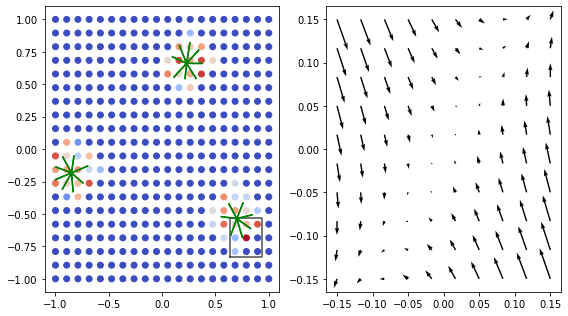

In [33]:
fig, ax = plt.subplots(1,2)

# calculate argmax of integrals
index = np.argmax(integrals)

best = np.array(trans[index])


# draw a box corners at best plus-minus radius
ax[0].plot([-radius+best[0],radius+best[0],radius+best[0],-radius+best[0],-radius+best[0]],[-radius+best[1],-radius+best[1],radius+best[1],radius+best[1],-radius+best[1]], color = 'black', alpha = 0.7)


ax[0].scatter(trans[:,0], translations[:,1], c = integrals, cmap = 'coolwarm')


plot_chain(chain, ax[0])


simple_vf_plot(vf, ax[1], radius = radius)

# make plot bigger
fig.set_size_inches(18.5/2, 10.5/2)


# add a colorbar
plt.show()

### Create aggregated transpositions

In [58]:
trans = create_grid(20)
radius = 0.23

multis = []
transposed_chains = []

for elem in chains:
    m, t = transpose(elem, radius=radius, trans=trans)
    multis.append(m)
    transposed_chains.append(t)

In [59]:
transposed_chains[0]

tensor([[[ 0.4033,  0.0000],
         [ 0.2964,  0.0723]],

        [[ 0.2299,  0.1774],
         [ 0.2964,  0.0723]],

        [[ 0.4033,  0.0000],
         [ 0.2964,  0.0723]],

        ...,

        [[-0.1338, -0.1766],
         [-0.2609, -0.1110]],

        [[-0.1338, -0.1766],
         [-0.0915, -0.2809]],

        [[-0.1338, -0.1766],
         [-0.2609, -0.1110]]])

# Calculate density


In [60]:
import torch.nn.functional as F
import torch.optim as optim
from scipy.stats import multivariate_normal
from sklearn.neighbors import KernelDensity

densities = []

# calculate the density of each of the nodes of each graph
# at each of the points in the grid of tranlsations.
for i in range(len(global_positions)):

    # get the positions of the nodes of the graph
    points = global_positions[i].values()

    # convert points to numpy array
    points = np.array(list(points))

    # estimate density of the points
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(points)

    # evaluate the density at each point in the grid
    Z = np.exp(kde.score_samples(trans))

    # append the density to the list of densities
    densities.append(torch.tensor(Z))

In [ ]:
# plot densities 0 over the grid
fig, ax = plt.subplots()

ax.scatter()

# Learning

In [53]:
# initialise a single hidden layer neural 1-form with two output feature 1-forms

vf = nn.Sequential(
    nn.Linear(2, 64),
    nn.ReLU(),
    nn.Linear(64, 2*2)
)

In [54]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(vf.parameters(), lr=1.5*1e-3)

# initialise a mean squared error loss function
criterion = nn.MSELoss()

In [55]:
# function for randomizing batches
def permute_list(l, p):
    """
    A function for permuting a list

    Parameters
    ----------
    l : list
        The list to be permuted

    p : list
        The permutation
    
    Returns
    -------
    out : list
        The permuted list
    """

    out = [l[i] for i in p]

    return out

In [56]:
# change element type in densities to flloat
for i in range(len(densities)):

    densities[i] = densities[i].float()



In [57]:
epochs = 10

batch_size = 200

losses = torch.zeros((batch_size,epochs))


for j in range(epochs):

    # shuffle the data
    perm = torch.randperm(batch_size)

    # permute the data
    transposed_chains = permute_list(transposed_chains, perm)
    multis = permute_list(multis, perm)
    labels = permute_list(labels, perm)
    chains = permute_list(chains, perm)
    densities = permute_list(densities, perm)
    

    correct = 0
        
    for i in range(batch_size):

        c = transposed_chains[i]

        m = multis[i]
        
        l = labels[i]

        l = torch.tensor(l)

        X = gen_CDM2(vf, c, d = 5)

        p = m @ X

        p = torch.abs(p)


        total = densities[i] @ p

        sm = torch.softmax(total, dim = 0)


        if torch.argmax(sm) == torch.argmax(l):
            correct += 1
             
        loss = criterion(sm,l.float())

        losses[i,j] = loss.detach()

        loss.backward()

        # for some reason it works better doing the backprop/gradient step after each path

        optimizer.step()

        optimizer.zero_grad()

        

    # clear print statement from previous iteration
    # clear_output(wait=True)
    
    print("Epoch = ", j, "Loss = ", torch.sum(losses[:,j])/batch_size)
    print("Correct: ", correct)



/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_25105/3510873685.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  l = torch.tensor(l)


Epoch =  0 Loss =  tensor(0.2819)
Correct:  106
Epoch =  1 Loss =  tensor(0.2799)
Correct:  101


KeyboardInterrupt: 

In [42]:
# print average losses of the model
print("Average loss = ", torch.sum(losses, dim = 0))

Average loss =  tensor([45.9386, 39.7773, 36.9221, 34.6805, 32.3285, 29.9556, 28.3840, 26.5021,
        24.9080, 23.3171])


### Interpreting the Results

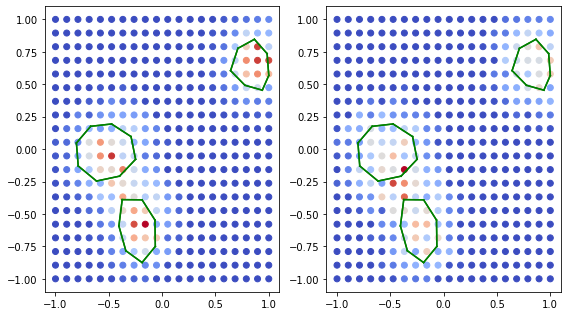

In [49]:
i = 54
chain = chains[i]
c = transposed_chains[i]
m = multis[i]
l = labels[i]


integrals = m @ torch.abs(gen_CDM2(vf, c, d = 5))

integrals.shape

integrals = integrals.detach().numpy()

# make a copy of densities
densities2 = densities.copy()

densities2 = densities2[i].detach().numpy()





fig, ax = plt.subplots(1,2)



ax[0].scatter(trans[:,0], trans[:,1], c = integrals[:,0] * densities2, cmap = 'coolwarm')

ax[1].scatter(trans[:,0], trans[:,1], c = integrals[:,1] * densities2, cmap = 'coolwarm')


plot_chain(chain, ax[0])

plot_chain(chain, ax[1])


# simple_vf_plot(vf, ax[1], radius = radius)

# make plot bigger
fig.set_size_inches(18.5/2, 10.5/2)


# add a colorbar
plt.show()

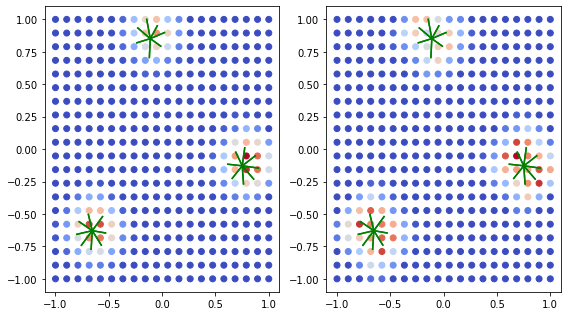

In [47]:
# select a chain
i = 60
chain = chains[i]

# calculate the integrals
c = transposed_chains[i]
m = multis[i]
l = labels[i]
integrals = m @ torch.abs(gen_CDM2(vf, c, d = 5))
integrals = integrals.detach().numpy()

# make a copy of densities
densities2 = densities.copy()
densities2 = densities2[i].detach().numpy()

# plot
fig, ax = plt.subplots(1,2)
ax[0].scatter(trans[:,0], trans[:,1], c = integrals[:,0] * (densities2**2), cmap = 'coolwarm')
ax[1].scatter(trans[:,0], trans[:,1], c = integrals[:,1] * (densities2**2), cmap = 'coolwarm')
plot_chain(chain, ax[0])
plot_chain(chain, ax[1])

# make plot bigger
fig.set_size_inches(18.5/2, 10.5/2)


# add a colorbar
plt.show()

/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_25105/839017781.py:29: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1, 2, i+1)


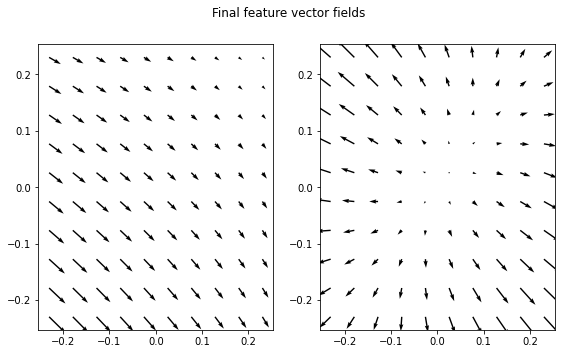

In [48]:
## plot a vector field given a function f: R^2 -> R^2
def plot_component_vf(f, ax, comp = 0, x_range=5, y_range=5):

    x = np.linspace(-x_range,x_range,10)
    y = np.linspace(-y_range,y_range,10)
    X,Y = np.meshgrid(x,y)

    X = torch.tensor(X).double()
    Y = torch.tensor(Y).double()


    U = np.zeros((10,10))
    V = np.zeros((10,10))
    for i in range(10):
        for j in range(10):
            inp = np.array([X[i,j],Y[i,j]])
            inp = torch.tensor(inp).float()

            tv = f.forward(inp).reshape(2,2)

            U[i,j] = tv[:,comp][0]
            V[i,j] = tv[:,comp][1]
    ax.quiver(X,Y,U,V)

fig, ax = plt.subplots()

# make a figure with 6 subplots arranged in 2 rows and 3 columns
for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    plot_component_vf(vf, ax, comp = i, x_range=radius, y_range=radius)


# add a title to the figure
fig.suptitle('Final feature vector fields')

# make plot bigger
fig.set_size_inches(18.5/2, 10.5/2)

plt.show()

# QM9

## Molecules in 3D


In [1]:
import dgl

data = dgl.data.QM9Dataset(label_keys=['mu', 'alpha', 'homo', 'lumo'])

In [96]:
# find max entry in Z for all graphs in data

max = 0
for graph in data:

    if torch.max(graph[0].ndata['Z']) > max:
        max = torch.max(graph[0].ndata['Z'])

print(max)

In [2]:
# plot a nx graph using the edges in graph.edges['uv'] and pos for positions
# a function for turning a path into a chain
def dgl_to_chain(graph):
    """ 
    A function for turning a graph into a chain
    """

    # get node features
    node_features = graph.ndata['R']

    # get edges
    u = graph.edges('uv')[0]
    v = graph.edges('uv')[1]
    edge_index = torch.stack((u,v)).T


    # number of 1-simplices
    r = edge_index.shape[0]

    # embedding dimension
    n = node_features.shape[1]

    # sort the edge indices
    edges = torch.tensor([np.sort([edge_index[i][0],edge_index[i][1]]) for i in range(len(edge_index))])

    # initialize chain
    ch = torch.zeros((r,2,n))

    # turn edges into a 1-chain
    for i in range(r):
        ch[i,0,:] = node_features[edges[i][0]]
        ch[i,1,:] = node_features[edges[i][1]]

    return ch

In [8]:
def plot_chain3d(chain, ax, dgraph= None, c = None):

    for i in range(chain.shape[0]):
        ax.plot(chain[i,:,0],chain[i,:,1], chain[i,:,2], c = 'black')
        # plot nodes
        
    if dgraph != None:
        
        # convert node features to numpy array

        
        for i in range(len(dgraph.ndata['Z'])):
            ax.scatter(dgraph.ndata['R'][i,0],dgraph.ndata['R'][i,1])



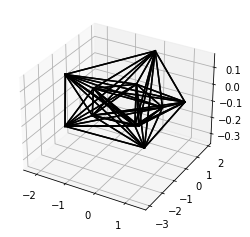

In [9]:
# plot 3d graph
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

graph = data[200][0]

chain = dgl_to_chain(graph)

plot_chain3d(chain,ax)
plt.show()



In [101]:
# use plotly to plot the 3d graph
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=graph.ndata['R'][:,0],
    y=graph.ndata['R'][:,1],
    z=graph.ndata['R'][:,2],
    mode='markers',
    marker=dict(
        size=12,
        color=graph.ndata['Z'],                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1
    )
)])

# add in the edges to the plot
for i in range(graph.edges('uv')[0].shape[0]):
    fig.add_trace(go.Scatter3d(
        x=[graph.ndata['R'][graph.edges('uv')[0][i]][0],graph.ndata['R'][graph.edges('uv')[1][i]][0]],
        y=[graph.ndata['R'][graph.edges('uv')[0][i]][1],graph.ndata['R'][graph.edges('uv')[1][i]][1]],
        z=[graph.ndata['R'][graph.edges('uv')[0][i]][2],graph.ndata['R'][graph.edges('uv')[1][i]][2]],
        mode='lines',
        line=dict(
            color='black',
            width=2,
        )
    ))




# supress trace information
fig.update_traces(showlegend=False)




# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()


AttributeError: 'tuple' object has no attribute 'ndata'

In [102]:
R = graph.ndata['R']

AttributeError: 'tuple' object has no attribute 'ndata'

In [103]:
Z = graph.ndata['Z']

AttributeError: 'tuple' object has no attribute 'ndata'

In [49]:
# one hot encode Z
Z_oh = torch.nn.functional.one_hot(Z)

Z.shape

torch.Size([11])

In [50]:
Z_oh = Z_oh.float()

In [73]:
# normalize non-zero columns of z_oh
Z_oh = Z_oh / Z_oh.sum(axis = 0)

# replaces nan values with 0
Z_oh = torch.nan_to_num(Z_oh)

Z_oh

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333],
        [0.0000, 0.2000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])

In [74]:
R.shape


torch.Size([11, 3])

In [75]:
base = R.T @ Z_oh

In [76]:
base = base[:,[1,6,7]]

In [77]:
Z

tensor([7, 6, 6, 7, 6, 7, 1, 1, 1, 1, 1])

In [78]:
# plot the non-trivial columns of base in 3d using plotly
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=base[0,:],
    y=base[1,:],
    z=base[2,:],
    mode='markers',
    marker=dict(
        size=20,
        color=[1,6,7],                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1,
        symbol = 'square'
    )
)])

# tight layou
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()


In [91]:
# use plotly to plot the 3d graph
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=graph.ndata['R'][:,0],
    y=graph.ndata['R'][:,1],
    z=graph.ndata['R'][:,2],
    mode='markers',
    marker=dict(
        size=12,
        color=graph.ndata['Z'],                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1
    )
)])


fig.add_trace(go.Scatter3d(
    x=base[0,:],
    y=base[1,:],
    z=base[2,:],
    mode='markers',
    marker=dict(
        size=20,
        color=[1,6,7],                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1,
        symbol = 'square'
    )
))

fig.add_trace(go.Scatter3d(
    x=[0,base[0,0]],
    y=[0,base[1,0]],
    z=[0,base[2,0]],
    mode='lines',
    line=dict(
        color=[1],
        colorscale='Viridis',
        width=6,
    )
))

fig.add_trace(go.Scatter3d(
    x=[0,base[0,1]],
    y=[0,base[1,1]],
    z=[0,base[2,1]],
    mode='lines',
    line=dict(
        color=[6],
        colorscale='Viridis',
        width=6,
    )
))
fig.add_trace(go.Scatter3d(
    x=[0,base[0,2]],
    y=[0,base[1,2]],
    z=[0,base[2,2]],
    mode='lines',
    line=dict(
        color=[7],
        colorscale='Viridis',
        width=6,
    )
))

# supress trace information
fig.update_traces(showlegend=False)




# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()



In [85]:
# plot vectors from the origin to each column of base
fig = go.Figure(data=[go.Scatter3d(
    x=[0,base[0,0]],
    y=[0,base[1,0]],
    z=[0,base[2,0]],
    mode='lines',
    line=dict(
        color='red',
        width=6,
    )
)])

fig.add_trace(go.Scatter3d(

In [92]:
# calculate the cross product of the first two columns of base
cross = torch.cross(base[:,0],base[:,1])
